In [2]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import json


def docvec(model):
    # docs = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))['data']
    # docs = docs[0:100]
    with open('../articles_data/all_articles_with_thumbnail_metadata.json') as f:
        papers = json.load(f)

    docs = [paper['article_title'] + ' ' + paper['abstract'] for paper in papers]
    doc_titles = [paper['article_title'] for paper in papers]


    embeddings = model.encode(docs, show_progress_bar=True)

    umap_embeddings = umap.UMAP(n_neighbors=5,
                                n_components=5,
                                metric='cosine').fit_transform(embeddings)

    cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                              metric='euclidean',
                              cluster_selection_method='eom').fit(umap_embeddings)



    # Prepare data
    umap_data = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    result['titles'] = doc_titles
    print(cluster.labels_.max())


    docs_df = pd.DataFrame(docs, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Titles'] = doc_titles
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})
    return result,cluster, docs, docs_df, docs_per_topic

In [24]:
model = SentenceTransformer('all-mpnet-base-v2')

result,cluster, docs, docs_df, docs_per_topic = docvec(model)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

15


In [25]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [26]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))

In [27]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [words[j] for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [28]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

{-1: ['rib', 'ct', 'labels', 'segmentation', 'context', 'noise'], 0: ['flow', 'cardiac', 'pc', 'heart', '4d', 'mri'], 1: ['molecular', 'protein', 'proteins', 'functional', 'molecule', 'connectivity'], 2: ['analytics', 'pathologists', 'pathology', 'thermal', 'digital', 'diagnostic'], 3: ['deep', 'learning', 'mitotic', 'mammogram', 'mg', 'classification'], 4: ['cta', 'arteries', 'artery', 'cerebral', 'vessels', 'cow'], 5: ['tensor', 'modeling', 'diffusion', 'maze', 'differences', 'researchers'], 6: ['ultrasound', 'hifu', 'liver', 'tracing', 'ray', 'fetus'], 7: ['virtual', 'reality', 'display', 'simulation', 'valve', 'stress'], 8: ['shape', 'polyp', 'automatic', 'curvature', 'smoothing', 'hough'], 9: ['fiber', 'tractography', 'crossing', 'tracts', 'diffusion', 'white'], 10: ['vascular', 'aneurysm', 'vessel', 'blood', 'bird', 'depth'], 11: ['ius', 'pet', 'tumor', 'roi', 'registration', 'volume'], 12: ['motion', 'registration', 'stage', 'lung', 'muscular', 'activity'], 13: ['skeleton', 'foo

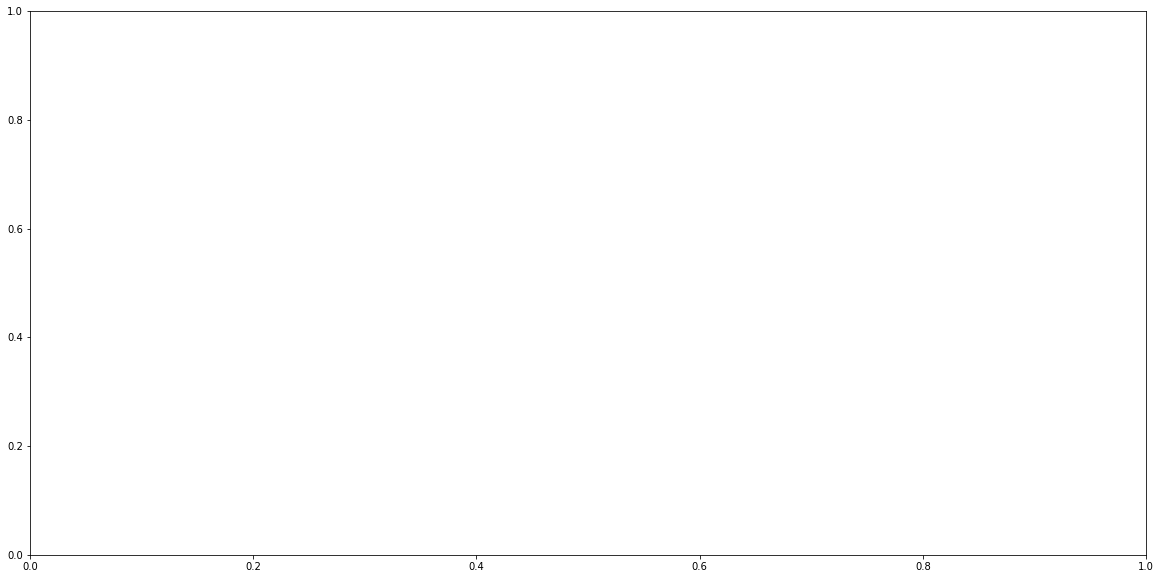

In [29]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=6)
print(top_n_words)
from collections import Counter
import plotly.graph_objects as go



# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plot_top=Counter() # to get only distinct labels, replace with a set and add a check here [1]
top_terms = top_n_words


top_terms_docs = ['.'.join(str(e) for e in top_terms[item]) for item in clustered.labels]
print(len(top_terms_docs))


# ax.scatter(outliers.x, outliers.y, color='#BDBDBD')
# print("clustered labels", clustered.labels)
# ax.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
#
#
# for i, lab, prob in zip(range(len(cluster.labels_)),cluster.labels_, cluster.probabilities_): # pointwise iteration
#         print("lab", lab)
#         print("i: ",i)
#         if lab != -1:
#             for el in top_terms[lab][:5]:
#                     print(i)
#                     # x[i], y[i] are the projected points in 2D space
#                     ax.annotate(el, (clustered.x[i],clustered.y[i]))
#                     break


import plotly.express as px
df = px.data.iris()
fig = px.scatter(x=clustered.x, y=clustered.y, color=top_terms_docs, hover_name=clustered.titles,
                 labels={"color" : "Topics"})
fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y, mode='markers', showlegend=False, hovertext=outliers.titles,
                                     name='Selected',
                                     marker=dict(
                                         color='#BDBDBD',
                                     ),
                                     hoverlabel=dict(
                                         bgcolor="#ffffff",
                                         font_size=12,
                                         font_color="#141414",
                                         font_family="Calibri",
                                         bordercolor="#BDBDBD",
                                     ),
                                    hovertemplate='<b>%{hovertext}<br></b><br>0=%{x}<br>1=%{y}'
                                     ))


In [357]:
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

,Topic,Size
0,-1,37
2,1,29
17,16,25
1,0,21
10,9,14
19,18,13
7,6,11
8,7,10
11,10,10
13,12,10


In [361]:
top_n_words[15]

['rib', 'segmentation', 'radiation', 'pelvic', 'segmentations', 'automatic']

In [117]:
top_n_words[15][:10]

[('ar', 0.014906447694789392),
 ('ultrasound', 0.014830173224860466),
 ('ray', 0.014435801652078747),
 ('hmd', 0.01333682446415577),
 ('haptics', 0.01333682446415577),
 ('gesture', 0.01333682446415577),
 ('biopsy', 0.012776955166962338),
 ('tracing', 0.011864190899598271),
 ('sln', 0.011665841079272123),
 ('touch', 0.011665841079272123)]

In [118]:
top_n_words[10][:10]

[('vascular', 0.023594408403621776),
 ('depth', 0.019329315590091947),
 ('vessel', 0.018631478036349774),
 ('tree', 0.017012707911122842),
 ('parameterization', 0.016555582224809098),
 ('vessels', 0.015975638281646127),
 ('xr', 0.015462662539558077),
 ('stress', 0.015023520622326635),
 ('blood', 0.014883646310110462),
 ('color', 0.013910985269266455)]

In [17]:
model1 = SentenceTransformer('allenai-specter')

In [18]:
result,cluster, docs, docs_df, docs_per_topic = docvec(model1)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

15


In [20]:

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))

In [21]:

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)


{-1: ['vessels', 'stress', 'neck', 'hifu', 'residual', 'colon', 'vessel', 'blood', 'lumen', 'wall'], 0: ['protein', 'molecular', 'proteins', 'cell', 'tunnels', 'molecules', 'properties', 'molecule', 'tunnel', 'level'], 1: ['fiber', 'diffusion', 'brain', 'connectivity', 'tensor', 'tractography', 'functional', 'crossing', 'neurons', 'tracts'], 2: ['analytics', 'sleep', 'rehabilitation', 'biomedical', 'communication', 'discovery', 'knowledge', 'staging', 'models', 'notes'], 3: ['evaluations', 'evaluation', 'studies', 'perception', 'user', 'surfaces', 'visualizations', 'aneurysm', 'web', 'medical'], 4: ['deep', 'pathologists', 'pathology', 'digital', 'learning', 'diagnostic', 'mitotic', 'mammogram', 'mg', 'classification'], 5: ['reality', 'virtual', 'vr', 'valve', 'training', 'mitral', 'haptic', 'interaction', 'simulation', 'xr'], 6: ['vascular', 'bird', 'vessel', 'parameterization', 'radar', 'depth', 'color', 'dependent', 'applicator', 'animation'], 7: ['registration', 'implant', 'motion'

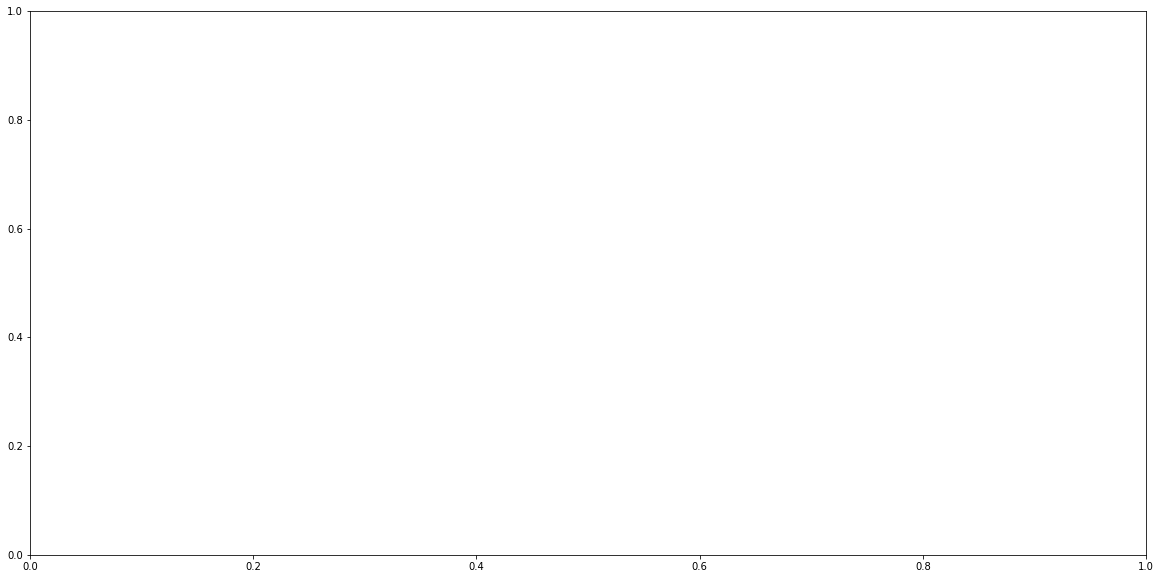

In [23]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
print(top_n_words)
from collections import Counter
import plotly.graph_objects as go




# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
pio.renderers.default = "browser"
plot_top=Counter() # to get only distinct labels, replace with a set and add a check here [1]
top_terms = top_n_words


top_terms_docs = ['.'.join(str(e) for e in top_terms[item]) for item in clustered.labels]



fig = px.scatter(x=clustered.x, y=clustered.y, color=top_terms_docs, hover_name=clustered.titles,
                 labels={"color" : "Topics"})
fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y, mode='markers', showlegend=False, hovertext=outliers.titles,
                                     name='Selected',
                                     marker=dict(
                                         color='#BDBDBD',
                                     ),
                                     hoverlabel=dict(
                                         bgcolor="#ffffff",
                                         font_size=12,
                                         font_color="#141414",
                                         font_family="Calibri",
                                         bordercolor="#BDBDBD",
                                     ),
                                    hovertemplate='<b>%{hovertext}<br></b><br>0=%{x}<br>1=%{y}'
                                     ))

In [370]:
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

,Topic,Size
0,-1,37
2,1,29
17,16,25
1,0,21
10,9,14
19,18,13
7,6,11
8,7,10
11,10,10
13,12,10


In [131]:
top_n_words[1][:10]

[('fiber', 0.032929810190857195),
 ('diffusion', 0.031988310329731),
 ('tensor', 0.023774861157086494),
 ('tractography', 0.02289201984294166),
 ('crossing', 0.020034806920963825),
 ('tracts', 0.017929453404837658),
 ('matter', 0.014394004309817222),
 ('white', 0.014394004309817222),
 ('dti', 0.013091680803717212),
 ('uncertainty', 0.013039795921343819)]

In [ ]:
topic_sizes = extract_topic_sizes(docs_df)


In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
def docvec():
    docs = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))['data']
    docs = docs[0:100]

    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(docs, show_progress_bar=True)
    print(embeddings)

    umap_embeddings = umap.UMAP(n_neighbors=5,
                                n_components=5,
                                metric='cosine').fit_transform(embeddings)

    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                              metric='euclidean',
                              cluster_selection_method='eom').fit(umap_embeddings)
    print(cluster)



    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    print(result['labels'])

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()

    docs_df = pd.DataFrame(docs, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})
    return docs, docs_df, docs_per_topic